In [ ]:
#This model creates an MNIST_CIFAR hybrid where it has to learn the CIFAR images

In [86]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
from PIL import Image
import random

# Function to add Gaussian noise
def add_gaussian_noise(tensor, mean=0.0, std=2):
    noise = torch.randn(tensor.size()) * std + mean
    noisy_tensor = tensor + noise
    return torch.clamp(noisy_tensor, 0, 1)

# Load MNIST
mnist_transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to match CIFAR
    transforms.Grayscale(num_output_channels=3),  # Convert to RGB
    transforms.ToTensor(),
    transforms.Lambda(lambda x: add_gaussian_noise(x, std=2))  # Apply Gaussian noise
])

mnist_data = torchvision.datasets.MNIST(root='./data', train=True, transform=mnist_transform, download=True)

# Load CIFAR-10
cifar_transform = transforms.Compose([
    transforms.ToTensor()
])

cifar_data = torchvision.datasets.CIFAR10(root='./data', train=True, transform=cifar_transform, download=True)
cifar_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Get CIFAR class indices (precompute for speed)
cifar_class_indices = {class_name: [] for class_name in cifar_data.classes}

# Store indices of CIFAR images per class
for i, (_, label) in enumerate(cifar_data):
    class_name = cifar_data.classes[label]
    cifar_class_indices[class_name].append(i)

# Create paired dataset (random pairing with CIFAR label as the label)
combined_images = []
combined_labels = []

for mnist_img, mnist_label in mnist_data:
    # Randomly select a CIFAR image and its label
    random_class_name = random.choice(cifar_labels)  # Randomly select class from CIFAR
    cifar_indices = cifar_class_indices[random_class_name]  # Get precomputed indices for that class
    
    if not cifar_indices:
        continue  # Skip if no images (shouldn't happen)

    # Select a random image from the CIFAR class
    cifar_idx = random.choice(cifar_indices)
    cifar_img, cifar_label = cifar_data[cifar_idx]

    # Concatenate images horizontally
    mnist_img = transforms.ToPILImage()(mnist_img)
    cifar_img = transforms.ToPILImage()(cifar_img)
    combined_img = Image.new('RGB', (64, 32))  # Create a new canvas
    combined_img.paste(mnist_img, (0, 0))
    combined_img.paste(cifar_img, (32, 0))

    # Convert back to tensor
    combined_tensor = transforms.ToTensor()(combined_img)
    
    # Store paired image and label (using CIFAR label)
    combined_images.append(combined_tensor)
    combined_labels.append(cifar_label)  # Now using CIFAR's label

# Convert to dataset
class MNISTCIFARDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

combined_dataset = MNISTCIFARDataset(combined_images, combined_labels)
combined_loader = DataLoader(combined_dataset, batch_size=32, shuffle=True)

print(f"Dataset successfully created with {len(combined_dataset)} images!")

Files already downloaded and verified
Dataset successfully created with 60000 images!


In [87]:
# Load MNIST
mnist_transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to match CIFAR
    transforms.Grayscale(num_output_channels=3),  # Convert to RGB
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.zeros_like(x)),
    #transforms.Lambda(lambda x: add_gaussian_noise(x, std=2))  # Apply Gaussian noise
])

mnist_data = torchvision.datasets.MNIST(root='./data', train=True, transform=mnist_transform, download=True)

# Load CIFAR-10
cifar_transform = transforms.Compose([
    transforms.ToTensor()
])

cifar_data = torchvision.datasets.CIFAR10(root='./data', train=True, transform=cifar_transform, download=True)
cifar_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Get CIFAR class indices (precompute for speed)
cifar_class_indices = {class_name: [] for class_name in cifar_data.classes}

# Store indices of CIFAR images per class
for i, (_, label) in enumerate(cifar_data):
    class_name = cifar_data.classes[label]
    cifar_class_indices[class_name].append(i)

# Create paired dataset (random pairing with CIFAR label as the label)
combined_images = []
combined_labels = []

for mnist_img, mnist_label in mnist_data:
    # Randomly select a CIFAR image and its label
    random_class_name = random.choice(cifar_labels)  # Randomly select class from CIFAR
    cifar_indices = cifar_class_indices[random_class_name]  # Get precomputed indices for that class
    
    if not cifar_indices:
        continue 

    # Select a random image from the CIFAR class
    cifar_idx = random.choice(cifar_indices)
    cifar_img, cifar_label = cifar_data[cifar_idx]

    # Concatenate images horizontally
    mnist_img = transforms.ToPILImage()(mnist_img)
    cifar_img = transforms.ToPILImage()(cifar_img)
    combined_img = Image.new('RGB', (64, 32))  # Create a new canvas
    combined_img.paste(mnist_img, (0, 0))
    combined_img.paste(cifar_img, (32, 0))

    # Convert back to tensor
    combined_tensor = transforms.ToTensor()(combined_img)
    
    # Store paired image and label (using CIFAR label)
    combined_images.append(combined_tensor)
    combined_labels.append(cifar_label)  # Now using CIFAR's label

# Convert to dataset
class MNISTCIFARDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

combined_dataset = MNISTCIFARDataset(combined_images, combined_labels)
combined_loader = DataLoader(combined_dataset, batch_size=32, shuffle=True)

print(f"Dataset successfully created with {len(combined_dataset)} images!")

Files already downloaded and verified
Dataset successfully created with 60000 images!


In [88]:
print(len(combined_dataset))  # Make sure it contains data

60000


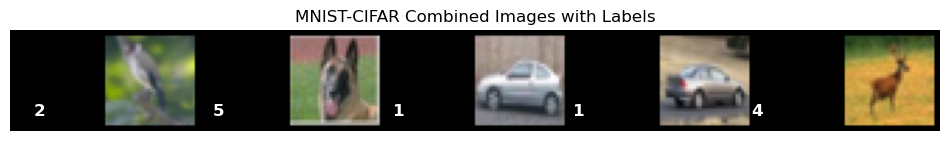

In [89]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Function to show a batch of combined MNIST-CIFAR images with their labels
def show_combined_images_with_labels(dataloader, num_images=5):
    data_iter = iter(dataloader)
    images, labels = next(data_iter)  # Get first batch

    # Select only the first `num_images` images
    images = images[:num_images]
    #images[:, :, :, :32] = 0
    labels = labels[:num_images]  # Corresponding labels

    # Create a grid of images
    grid_img = vutils.make_grid(images, nrow=num_images, padding=2, normalize=True)

    # Display the images
    plt.figure(figsize=(12, 4))
    plt.imshow(grid_img.permute(1, 2, 0))  # Change from (C, H, W) to (H, W, C) for display
    plt.axis("off")

    # Add labels to the images
    for i in range(num_images):
        label = labels[i].item()  # Get label (make sure it's a scalar)
        plt.text(
            i * 64 + 8,  # x position
            30,  # y position (near the bottom of the image)
            str(label),  # Label text
            color='white',  # White color for the text
            fontsize=12,
            fontweight='bold'
        )

    plt.title("MNIST-CIFAR Combined Images with Labels")
    plt.show()

# Call function to display images with labels
show_combined_images_with_labels(combined_loader)


In [90]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # First convolution layer: (3, 64, 32) -> (6, 60, 28)
        self.conv1 = nn.Conv2d(3, 6, 5)  
        
        # Maxpooling layer: (6, 60, 28) -> (6, 30, 14)
        self.pool = nn.MaxPool2d(2, 2) 
        
        # Second convolution layer: (6, 30, 14) -> (16, 26, 10)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # Maxpooling layer: (16, 26, 10) -> (16, 13, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # Fully connected layer: (16 * 13 * 5) -> 120
        self.fc1 = nn.Linear(16 * 13 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Apply first convolution and pooling
        x = self.pool(F.relu(self.conv1(x)))  
        
        # Apply second convolution and pooling
        x = self.pool2(F.relu(self.conv2(x))) 
        
        # Flatten the output to pass it to the fully connected layers
        x = x.view(-1, 16 * 13 * 5)  # New size: 16 * 13 * 5 after two poolings
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

# Instantiate the model
net = Net()

In [95]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [96]:
import os

# Define paths
model_directory_path = 'model/'
model_path = os.path.join(model_directory_path, 'cifar-mnist-cnn-model.pt')

# Ensure directory exists
if not os.path.exists(model_directory_path):
    os.makedirs(model_directory_path)

def load_model(net):
    """Loads the trained model if it exists."""
    if os.path.isfile(model_path):
        net.load_state_dict(torch.load(model_path))
        print('Loaded model parameters from disk.')
        return True  # Indicate successful loading
    else:
        print('No saved model found.')
        return False

def train_model(net, trainloader, criterion, optimizer, epochs=2):
    """Trains the model from scratch."""
    print("Starting training...")
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 200 == 199:  # Print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
    print('Finished Training.')

In [97]:
train_model(net, combined_loader, criterion, optimizer, 10)

Starting training...
[1,   200] loss: 0.230
[1,   400] loss: 0.223
[1,   600] loss: 0.199
[1,   800] loss: 0.182
[1,  1000] loss: 0.176
[1,  1200] loss: 0.169
[1,  1400] loss: 0.162
[1,  1600] loss: 0.160
[1,  1800] loss: 0.154
[2,   200] loss: 0.150
[2,   400] loss: 0.149
[2,   600] loss: 0.148
[2,   800] loss: 0.143
[2,  1000] loss: 0.143
[2,  1200] loss: 0.142
[2,  1400] loss: 0.139
[2,  1600] loss: 0.138
[2,  1800] loss: 0.139
[3,   200] loss: 0.133
[3,   400] loss: 0.131
[3,   600] loss: 0.130
[3,   800] loss: 0.129
[3,  1000] loss: 0.127
[3,  1200] loss: 0.128
[3,  1400] loss: 0.129
[3,  1600] loss: 0.122
[3,  1800] loss: 0.128
[4,   200] loss: 0.116
[4,   400] loss: 0.117
[4,   600] loss: 0.117
[4,   800] loss: 0.120
[4,  1000] loss: 0.113
[4,  1200] loss: 0.114
[4,  1400] loss: 0.116
[4,  1600] loss: 0.116
[4,  1800] loss: 0.115
[5,   200] loss: 0.105
[5,   400] loss: 0.110
[5,   600] loss: 0.106
[5,   800] loss: 0.108
[5,  1000] loss: 0.107
[5,  1200] loss: 0.104
[5,  1400] lo

In [81]:
def calculate_class_accuracies(model, testloader, classes):
    # Set model to evaluation mode
    model.eval()
    
    # Initialize variables to track correct predictions for each class
    class_correct = [0] * len(classes)
    class_total = [0] * len(classes)

    # Iterate through the test dataset
    with torch.no_grad():  # Don't compute gradients during evaluation
        for data in testloader:
            images, labels = data  # Get images and corresponding labels
            outputs = model(images)  # Get model outputs
            _, predicted = torch.max(outputs, 1)  # Get predicted labels

            # Update correct predictions for each class
            for i in range(len(labels)):
                label = labels[i].item()
                class_total[label] += 1
                if predicted[i].item() == label:
                    class_correct[label] += 1

    # Print accuracy for each class
    for i in range(len(classes)):
        accuracy = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        print(f'Accuracy for {classes[i]}: {accuracy:.2f}%')

# The 'classes' should be a list of class names for your dataset (e.g., CIFAR-10 classes)

# Define class names (CIFAR-10 example)
cifar_mnist_classes = ['airplane 0', 'automobile 1', 'bird 2', 'cat 3', 'deer 4', 'dog 5', 
                 'frog 6', 'horse 7', 'ship 8', 'truck 9']
cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Call the function to calculate and print class-wise accuracies
calculate_class_accuracies(net, combined_loader, cifar_classes)

Accuracy for airplane: 89.06%
Accuracy for automobile: 92.45%
Accuracy for bird: 79.64%
Accuracy for cat: 82.25%
Accuracy for deer: 86.28%
Accuracy for dog: 80.92%
Accuracy for frog: 89.88%
Accuracy for horse: 91.65%
Accuracy for ship: 93.51%
Accuracy for truck: 92.33%


In [25]:
#net2 = torch.load('model_cifar_mnist_2b_full.pth')

/var/folders/w5/cr9dv6h106v9sddn3p0_pt200000gn/T/ipykernel_929/4040050759.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net2 = torch.load('model_cifar_mnist_2b_full.pt

In [82]:
total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for data in combined_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

Model accuracy on 60000 test images: 87.80%


In [83]:
total_correct_2 = 0
total_images_2 = 0
confusion_matrix = np.zeros([10,10], int)

with torch.no_grad():
    for data in combined_loader:
        images, labels = data

        # Blackout MNIST side (left half of the image)
        images[:, :, :, :32] = 0  # Assuming image shape (B, C, H, W)

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images_2 += labels.size(0)
        total_correct_2 += (predicted == labels).sum().item()
        
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

mnist_blackout_accuracy = total_correct_2 / total_images_2 * 100
print('Model accuracy with MNIST blacked out: {:.2f}%'.format(mnist_blackout_accuracy))

Model accuracy with MNIST blacked out: 81.26%


In [84]:
total_correct_3 = 0
total_images_3 = 0
confusion_matrix = np.zeros([10,10], int)

with torch.no_grad():
    for data in combined_loader:
        images, labels = data

        # Blackout CIFAR side (right half of the image)
        images[:, :, :, 32:] = 0  # Assuming image shape (B, C, H, W)

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images_3 += labels.size(0)
        total_correct_3 += (predicted == labels).sum().item()
        
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

cifar_blackout_accuracy = total_correct_3 / total_images_3 * 100
print('Model accuracy with CIFAR blacked out: {:.2f}%'.format(cifar_blackout_accuracy))

Model accuracy with CIFAR blacked out: 10.27%


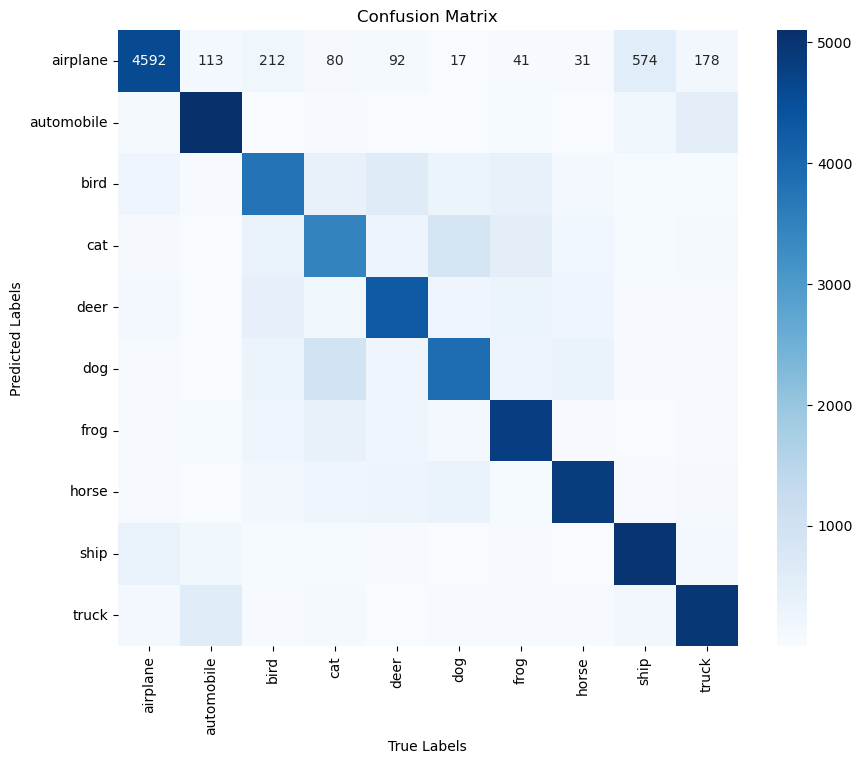

In [50]:
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, testloader, classes):
    # Set the model to evaluation mode
    model.eval()

    # Initialize lists to hold true labels and predicted labels
    all_labels = []
    all_preds = []

    # Iterate over the test dataset
    with torch.no_grad():  # Don't compute gradients during evaluation
        for data in testloader:
            images, labels = data  # Get images and corresponding labels
            outputs = model(images)  # Get model outputs
            _, predicted = torch.max(outputs, 1)  # Get predicted labels

            all_labels.extend(labels.cpu().numpy())  # Convert to CPU and extend
            all_preds.extend(predicted.cpu().numpy())  # Convert to CPU and extend

    # Calculate the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot the confusion matrix using Seaborn's heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('True Labels')
    plt.ylabel('Predicted Labels')
    plt.show()

# Example usage: Assuming testloader and class names are defined
# The 'classes' should be a list of class names for your dataset (e.g., CIFAR-10 classes)

# Call the function to calculate and plot the confusion matrix
plot_confusion_matrix(net, combined_loader, cifar_classes)

In [85]:
torch.save(net, 'model_cifar_mnist_2c_full.pth')